In [17]:
import dotenv
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import pandas as pd

# Load environment variables from .env file
dotenv.load_dotenv()
api_key = os.getenv("API_KEY")

In [24]:
from google import genai

client = genai.Client(api_key = api_key)

In [25]:
my_file = client.files.upload(file=image_path)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[my_file, "Caption this image."],
)

print(response.text)

Here are a few caption options for the image you sent, focusing on different aspects:

**Short & Sweet:**

*   "Nutrition facts and ingredients for a healthy snack."
*   "Close-up of a food package label."
*   "Checking the nutritional information."

**More Descriptive:**

*   "The back of a bag of snacks showing the nutrition facts panel and ingredient list. A whole foods product."
*   "A detailed view of the nutrition information on a snack bag, highlighting calories, fat, and other key values."
*   "Nutrition facts panel from the back of a Whole Foods Brand snack. Great for those checking ingredients and nutritional content."

**If you want to give me some context on what the image is or what you are trying to communicate, I can provide a more tailored caption.**


In [ ]:
images_data = pd.read_csv("Dataset/metadata/image_data.csv")
images_data.head()

,image_id,image_path,listing
0,71dZhpsferL,Dataset/final_dataset/c20aa6ca.jpg,"{""brand"": [{""language_tag"": ""en_IN"", ""value"": ..."
1,71vX7qIEAIL,Dataset/final_dataset/3079540e.jpg,"{""brand"": [{""language_tag"": ""en_IN"", ""value"": ..."
2,A1EZF-2mB5L,Dataset/final_dataset/f9a7cb71.jpg,"{""brand"": [{""language_tag"": ""en_AE"", ""value"": ..."
3,81o9EyZ-fAL,Dataset/final_dataset/26ae5dfc.jpg,"{""item_dimensions"": {""height"": {""normalized_va..."
4,81xaJCVnl3L,Dataset/final_dataset/5d8f395f.jpg,"{""brand"": [{""language_tag"": ""en_IN"", ""value"": ..."


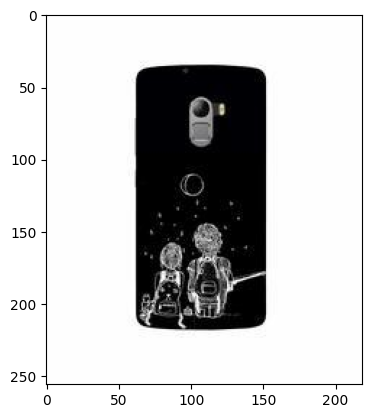

In [31]:
# open image
image_path = r"Dataset/final_dataset/c20aa6ca.jpg"
img = mpimg.imread(image_path)
plt.imshow(img)

In [61]:
def test_response(image_path,prompt):
    response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[image_path, prompt],
    )

    return response.text

In [66]:
def chat_response(image_path, user_prompt, system_prompt):
    # Read the image as binary
    with open(image_path, "rb") as img_file:
        image_data = img_file.read()

    # Define the content with system and user messages
    contents = [
        # {
        #     "role": "system",
        #     "parts": [
        #         {"text": system_prompt}
        #     ]
        # },
        {
            "role": "user",
            "parts": [
                {"inline_data": {"mime_type": "image/jpeg", "data": image_data}},
                {"text": system_prompt+user_prompt}
            ]
        }
    ]

    # Initialize the model
    model = "gemini-2.0-flash"

    # Generate the response
    response = client.models.generate_content(model=model, contents=contents)

    return response.text

In [67]:
def get_keywords(data):
    vqa_data = {}
    vqa_data["item_keywords"] = [kw.get("value", "") for kw in data.get("item_keywords", []) if kw.get("language_tag", "").startswith('en')]
    temp = vqa_data["item_keywords"].copy()
    keywords = ['color']
    for i in range(min(5, len(temp))):
        keywords.append(temp[i])
    return keywords

In [68]:
for i in range(3):
    image = images_data.iloc[i]['image_path']
    image_id = images_data.iloc[i]['image_id']
    listing = images_data.iloc[i]['listing']
    listing = json.loads(listing)
    keywords = get_keywords(listing)
    print(keywords)

['color', 'mobile cover', 'back cover', 'mobile case', 'phone case', 'mobile panel']
['color', 'mobile cover', 'back cover', 'mobile case', 'phone case', 'mobile panel']
['color', 'small', 'de', 'fur', 'rooms', 'navidad']


In [73]:
# Define the file path
csv_file_path = "Dataset/metadata/image_data_with_vqa.csv"

# Check if the file exists
if not os.path.exists(csv_file_path):
    # If the file doesn't exist, create a new DataFrame with random values
    l = len(images_data)
    data = {
        "image_id": [f"" for _ in range(l)],  # Example random IDs
        "image_path": [f"" for _ in range(l)],  # Example random paths
        "vqa_responses": ["" for _ in range(l)]  # Random responses
    }
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a CSV file
    os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)  # Ensure the directory exists
    df.to_csv(csv_file_path, index=False)
    print(f"File created: {csv_file_path}")
else:
    print(f"File already exists: {csv_file_path}")

File created: Dataset/metadata/image_data_with_vqa.csv


In [ ]:
system_prompt = """
You are a Visual Question Answering (VQA) dataset generator.
Given an image and a list of metadata strings, generate diverse, high-quality question-answer pairs that cover visual recognition, attributes, relationships, metadata, and reasoning.
Output each pair as list.
"""
vqa_responses = []
for i in range(1):
    image = images_data.iloc[i]['image_path']
    image_id = images_data.iloc[i]['image_id']
    listing = images_data.iloc[i]['listing']
    listing = json.loads(listing)
    keywords = get_keywords(listing)
    user_prompt = f"""
    Image ID: {image_id}
    Metadata: {keywords}
    Generate 2-3 question-answer pairs.
    """

    response = chat_response(image, user_prompt, system_prompt)
    print(response)
    
# Save the responses to a CSV file
# images_data['vqa_response'] = vqa_responses
# images_data.to_csv("Dataset/metadata/image_data_with_vqa.csv", index=False)
    

Here are some question-answer pairs based on the image and metadata:

```json
[
  ["What color is the phone case?", "black"],
  ["What type of cover is this?", "back cover"]
]
```
['Here are some question-answer pairs based on the image and metadata:\n\n```json\n[\n  ["What color is the phone case?", "black"],\n  ["What type of cover is this?", "back cover"]\n]\n```']


ValueError: Length of values (1) does not match length of index (19795)